# Johnson-Lindenstrauss transform demonstration on genomics data

In [1]:
%pip install ..

Processing /home/sean/Workspaces/jlt
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for jlt, since package 'wheel' is not installed.
  Attempting uninstall: jlt
    Found existing installation: jlt 0.1
    Uninstalling jlt-0.1:
      Successfully uninstalled jlt-0.1
  Running setup.py install for jlt ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, glob, time
import numpy as np
from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import jlt

### Load genomics data
We apply the Johnson-Lindenstrauss transform to several genomics data-sets. Each data-set contains the gene expression levels for $d$ genes of $n$ patients. 

The data are stored in a $d\times n$ matrix $X$ where column vectors represent patients and row-vectors represent. For each, $n\approx 100$ and $d\gg n$.

In [3]:
data_dir = '../data'
n_files = len(glob.glob(os.path.join(f'{data_dir}/*.mat')))
data = np.ndarray((n_files,), dtype=object)
for idx, fname in enumerate(os.listdir(data_dir)):
    fpath = os.path.join(data_dir,fname)
    if not os.path.isfile(fpath):
        continue
    X = np.ascontiguousarray(loadmat(fpath)['data']) # MATLAB uses column-majaor format, but we expect row-major
    data[idx] = X

## The Johnson-Lindenstrauss transform
The Johnson-Lindenstrauss transform is a method by which we can reduce the dimensionality of a data-set by applying a random matrix to it. For the ordinary Johnson-Lindenstrauss transfor (`jl` in `src/jltransform_module.c`), we generate the matrix $$A=[a_{ij}]; \qquad a_{i,j}\sim N(0,1)$$ and produe the domension-reduced data set $$Y=\frac{1}{\sqrt{k}}AX.$$ The transform matrix $A$ is $k\times d$ and $Y$ is $k\times n$ where $k\ll d$. In this notebook, we will consider `k=25,100,225,400`.

The "fast" Johnson-Lindenstrauss transform (`fastjl` in `src/jltransform_module.c`) is performed similarly, except where $$a_{i,j}=\begin{cases} -1 & \text{with probability } 1/6 \\ +1 & \text{with probability } 1/6 \end{cases}$$ and zero otherwise.

## Scatter plots of pairwise distances pre- and post-transform
One advantage of the Johnson-Lindenstrauss transform is that it for well-chosen values of $k$ it almost preserves the pairwise distances of column vectors with high probability. Here, we seek to experimentally verify this behavior.

In order to do so, we consider the pariwise distances of the un-transformed column vectors, $$D_{j,l}=\|X_j-X_l\|^2=\sum_{i=1}^{d}(X_{i,j}-X_{j,l})^2$$ and those of the transformed matrix, $$C_{j,l}=\|Y_j-Y_l\|^2.$$ These distances are plotted against each other below.

We see that the pre- and post-transform pairwise distances are strongly correlated when $k$ is relatively large, but they become less strongly correlated as the dimension of the target space of the transform becomes smaller.

In [4]:
def _scatter(ax, xs, ys, norm=None):
    # calculate point density
    xy = np.vstack([xs, ys])
    density = gaussian_kde(xy)(xy)

    # normalize density for consistency across axes
    if not norm:
        norm = mcolors.Normalize(vmin=density.min(), vmax=density.max())

    # scatter plot colored by density
    scatter = ax.scatter(xs, ys,
                         s=10,
                         c=density,
                         cmap='plasma',
                         norm=norm,
                         alpha=0.6)

    # hide all except the bottom spine
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    return scatter, norm

In [5]:
def _multi_scatter_subfig(fig, axes, X, D, ks, cbar=True, fast=False):
    scatters = []
    norm = None
    
    for idx, ax in enumerate(axes.ravel()):
        # evaluate the transform
        if fast:
            Y = jlt.fastjl(X, ks[idx])
        else:
            Y = jlt.jl(X, ks[idx])

        # compute new pariwise distances
        C = pdist(Y.T, metric='sqeuclidean')

        # scatter plot the distances against each other
        scatter, norm = _scatter(ax, D, C, norm=norm)
        scatters.append(scatter)

        # annotations
        ax.set_title(rf'Low dimension: $k={ks[idx]}$')
    
    # optionally add a colorbar
    if cbar:
        fig.colorbar(scatters[0], ax=axes, orientation='vertical', label='Point Density')

In [6]:
def _multi_scatter_supfig(data, ks, fast=False):
    # create main figure and subfigures
    fig = plt.figure(layout='constrained', figsize=(16, 22))
    subfigs = fig.subfigures(6, 1, hspace=0.05)
    
    for idx, subfig in enumerate(subfigs.ravel()):
        # make a subplots layout of axes
        axes = subfig.subplots(1,4, sharey=True)

        # get the correspoinding dataset and compute pariwise distances
        X = data[idx]
        D = pdist(X.T, metric='sqeuclidean')

        # make a multi-scatter plot on the axes
        _multi_scatter_subfig(subfig, axes, X, D, ks, fast=fast)

        # subfigure annotations
        subfig.suptitle(f'Dataset: data{idx+1}.mat',
                        fontweight='bold')
        
    # main figure annotations
    fig.suptitle(f"Pairwise square Euclidean distance between column vectors pre-\nand post-{'Fast ' if fast else ''}Johnson-Lindenstrauss transform\n",
                fontsize=16, fontweight='bold')
    
    return fig

In [7]:
ks=np.array([25, 100, 225, 400])

The figures below show the pre- and post-transform pairwise distances between column vectors in $X$ and $Y$, respectively, for both the ordinary and fast Johnson-Lindenstrauss transform. The elements of $D$, the distances between the $X_i$, are on the x-axis, and those of $C$, the corresponding matrix for the $Y_i$, are on the y-axis. The points $(D_{i,j}, C_{i,j})$ are colored according to their density for each data-set and for each $k$.

While certain data-sets are inherently more tightly clustered than others, it is clear that the transform tends to "spread out" the distances between patients to a greater degree when the dimension of the target space is smaller. 

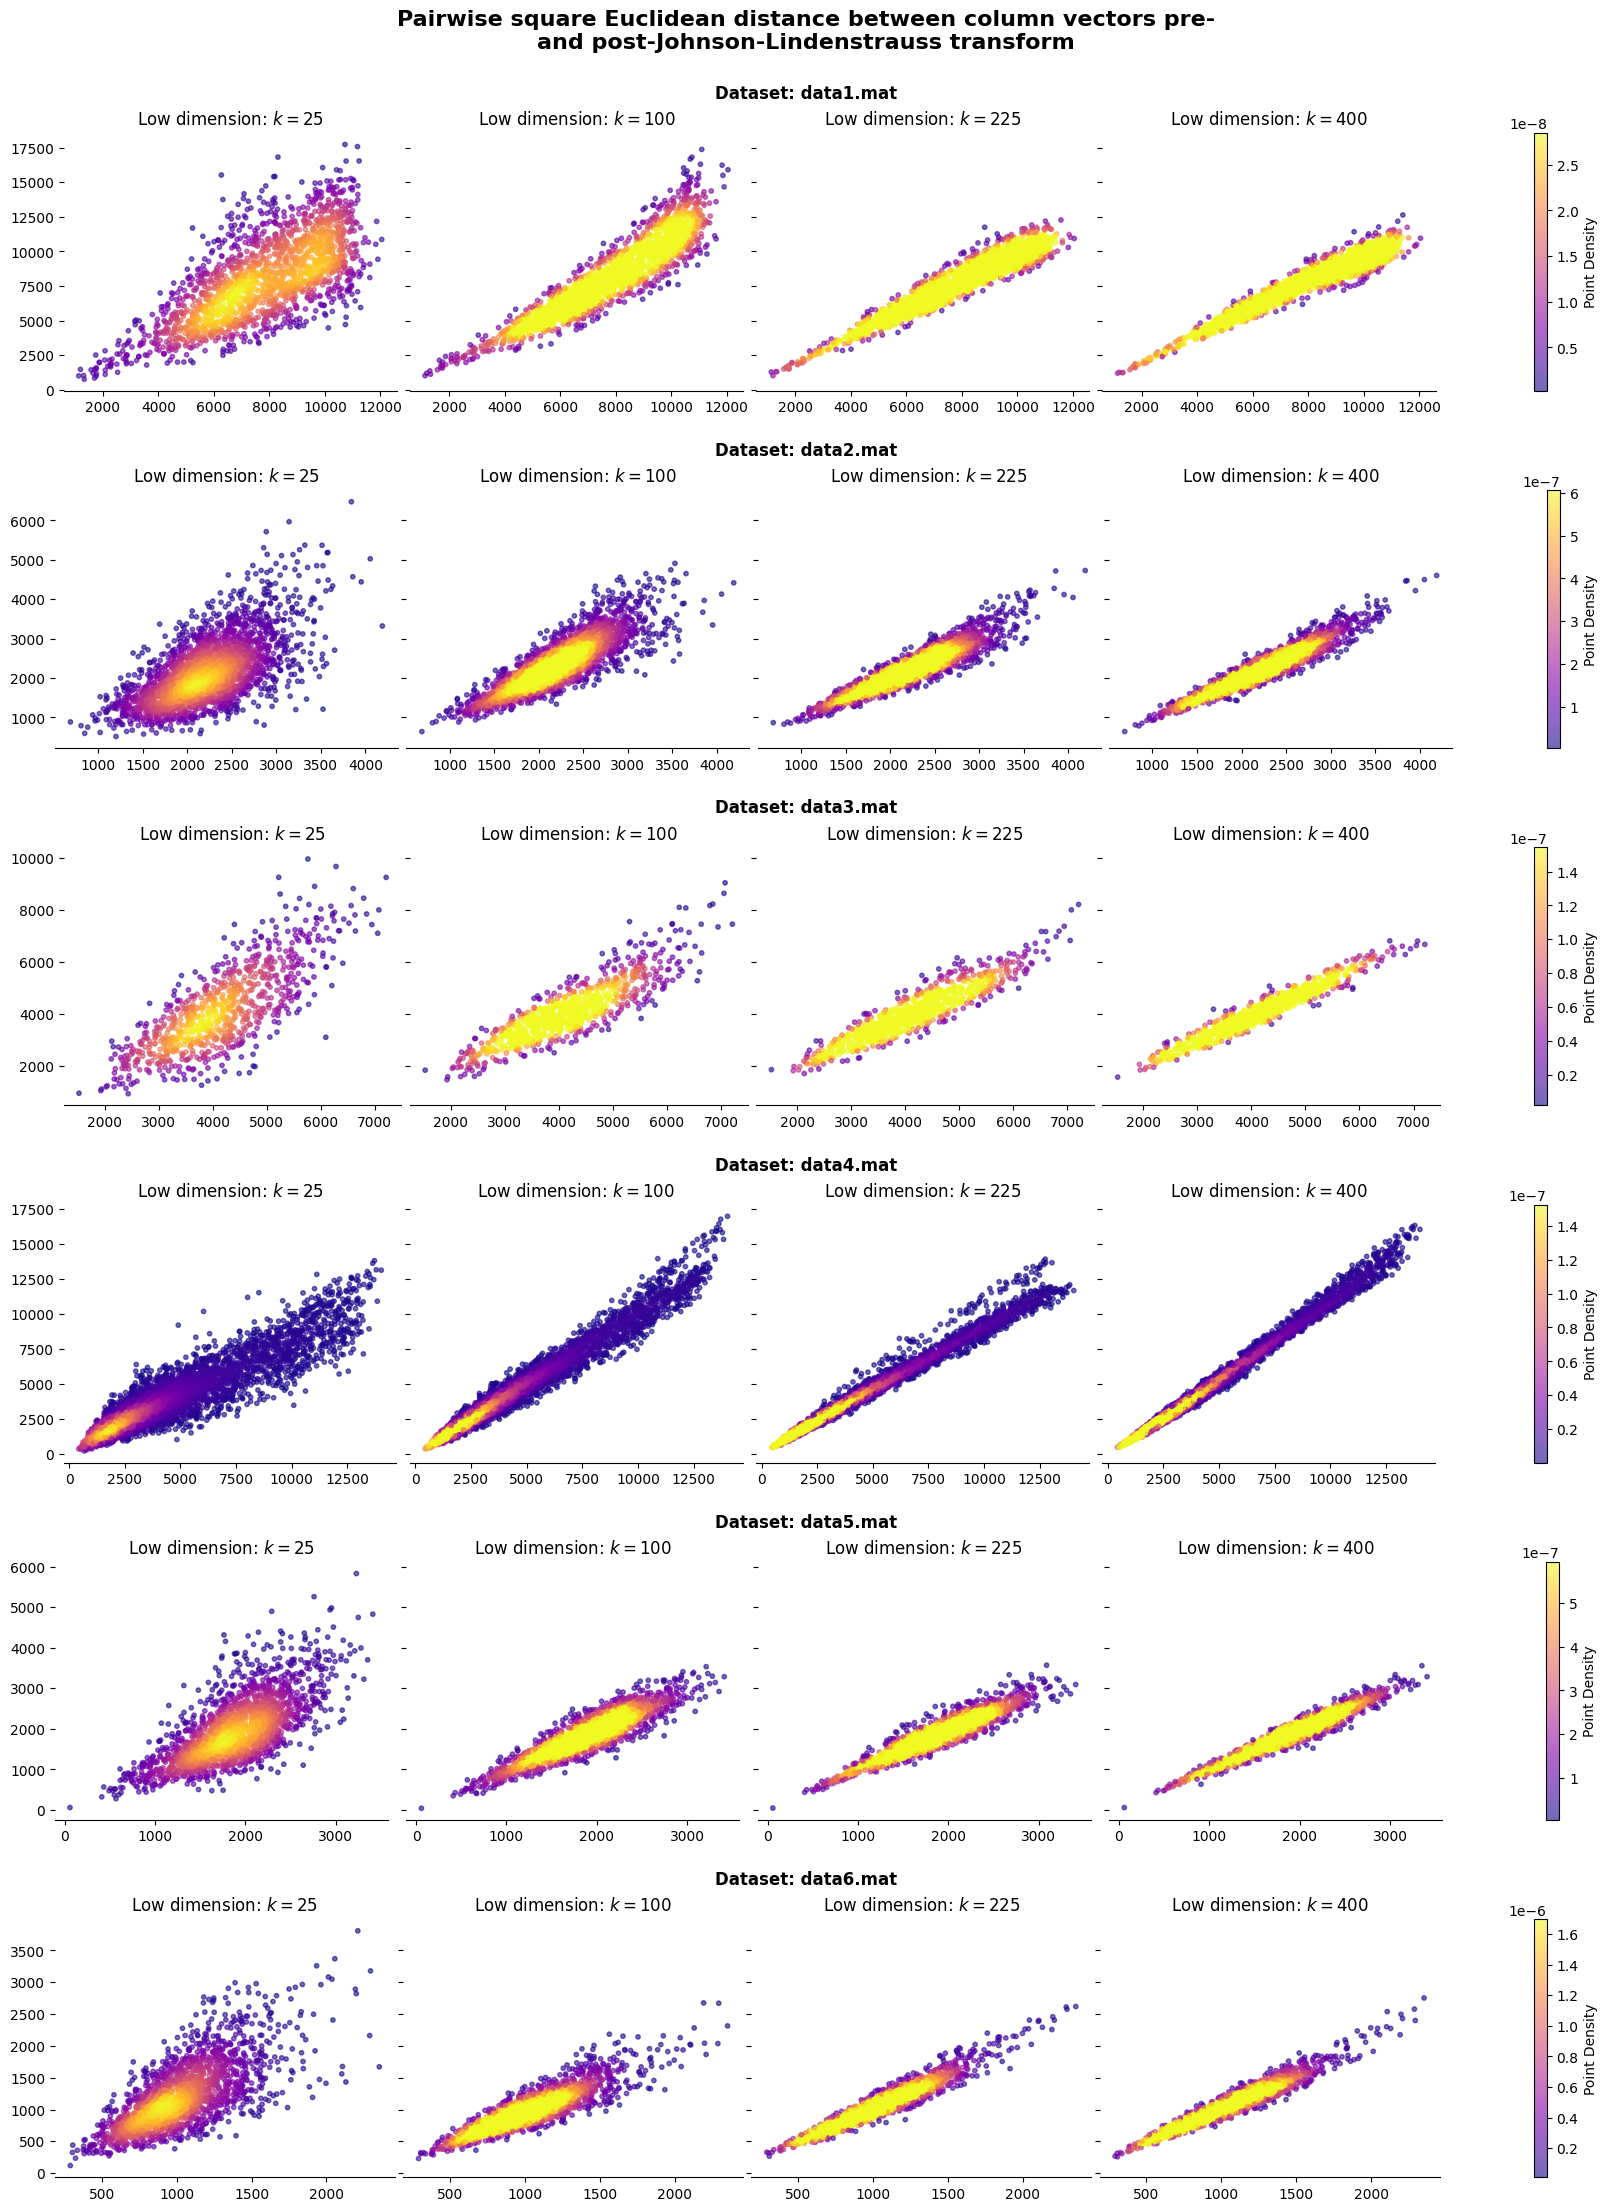

In [8]:
fig = _multi_scatter_supfig(data, ks, fast=False)

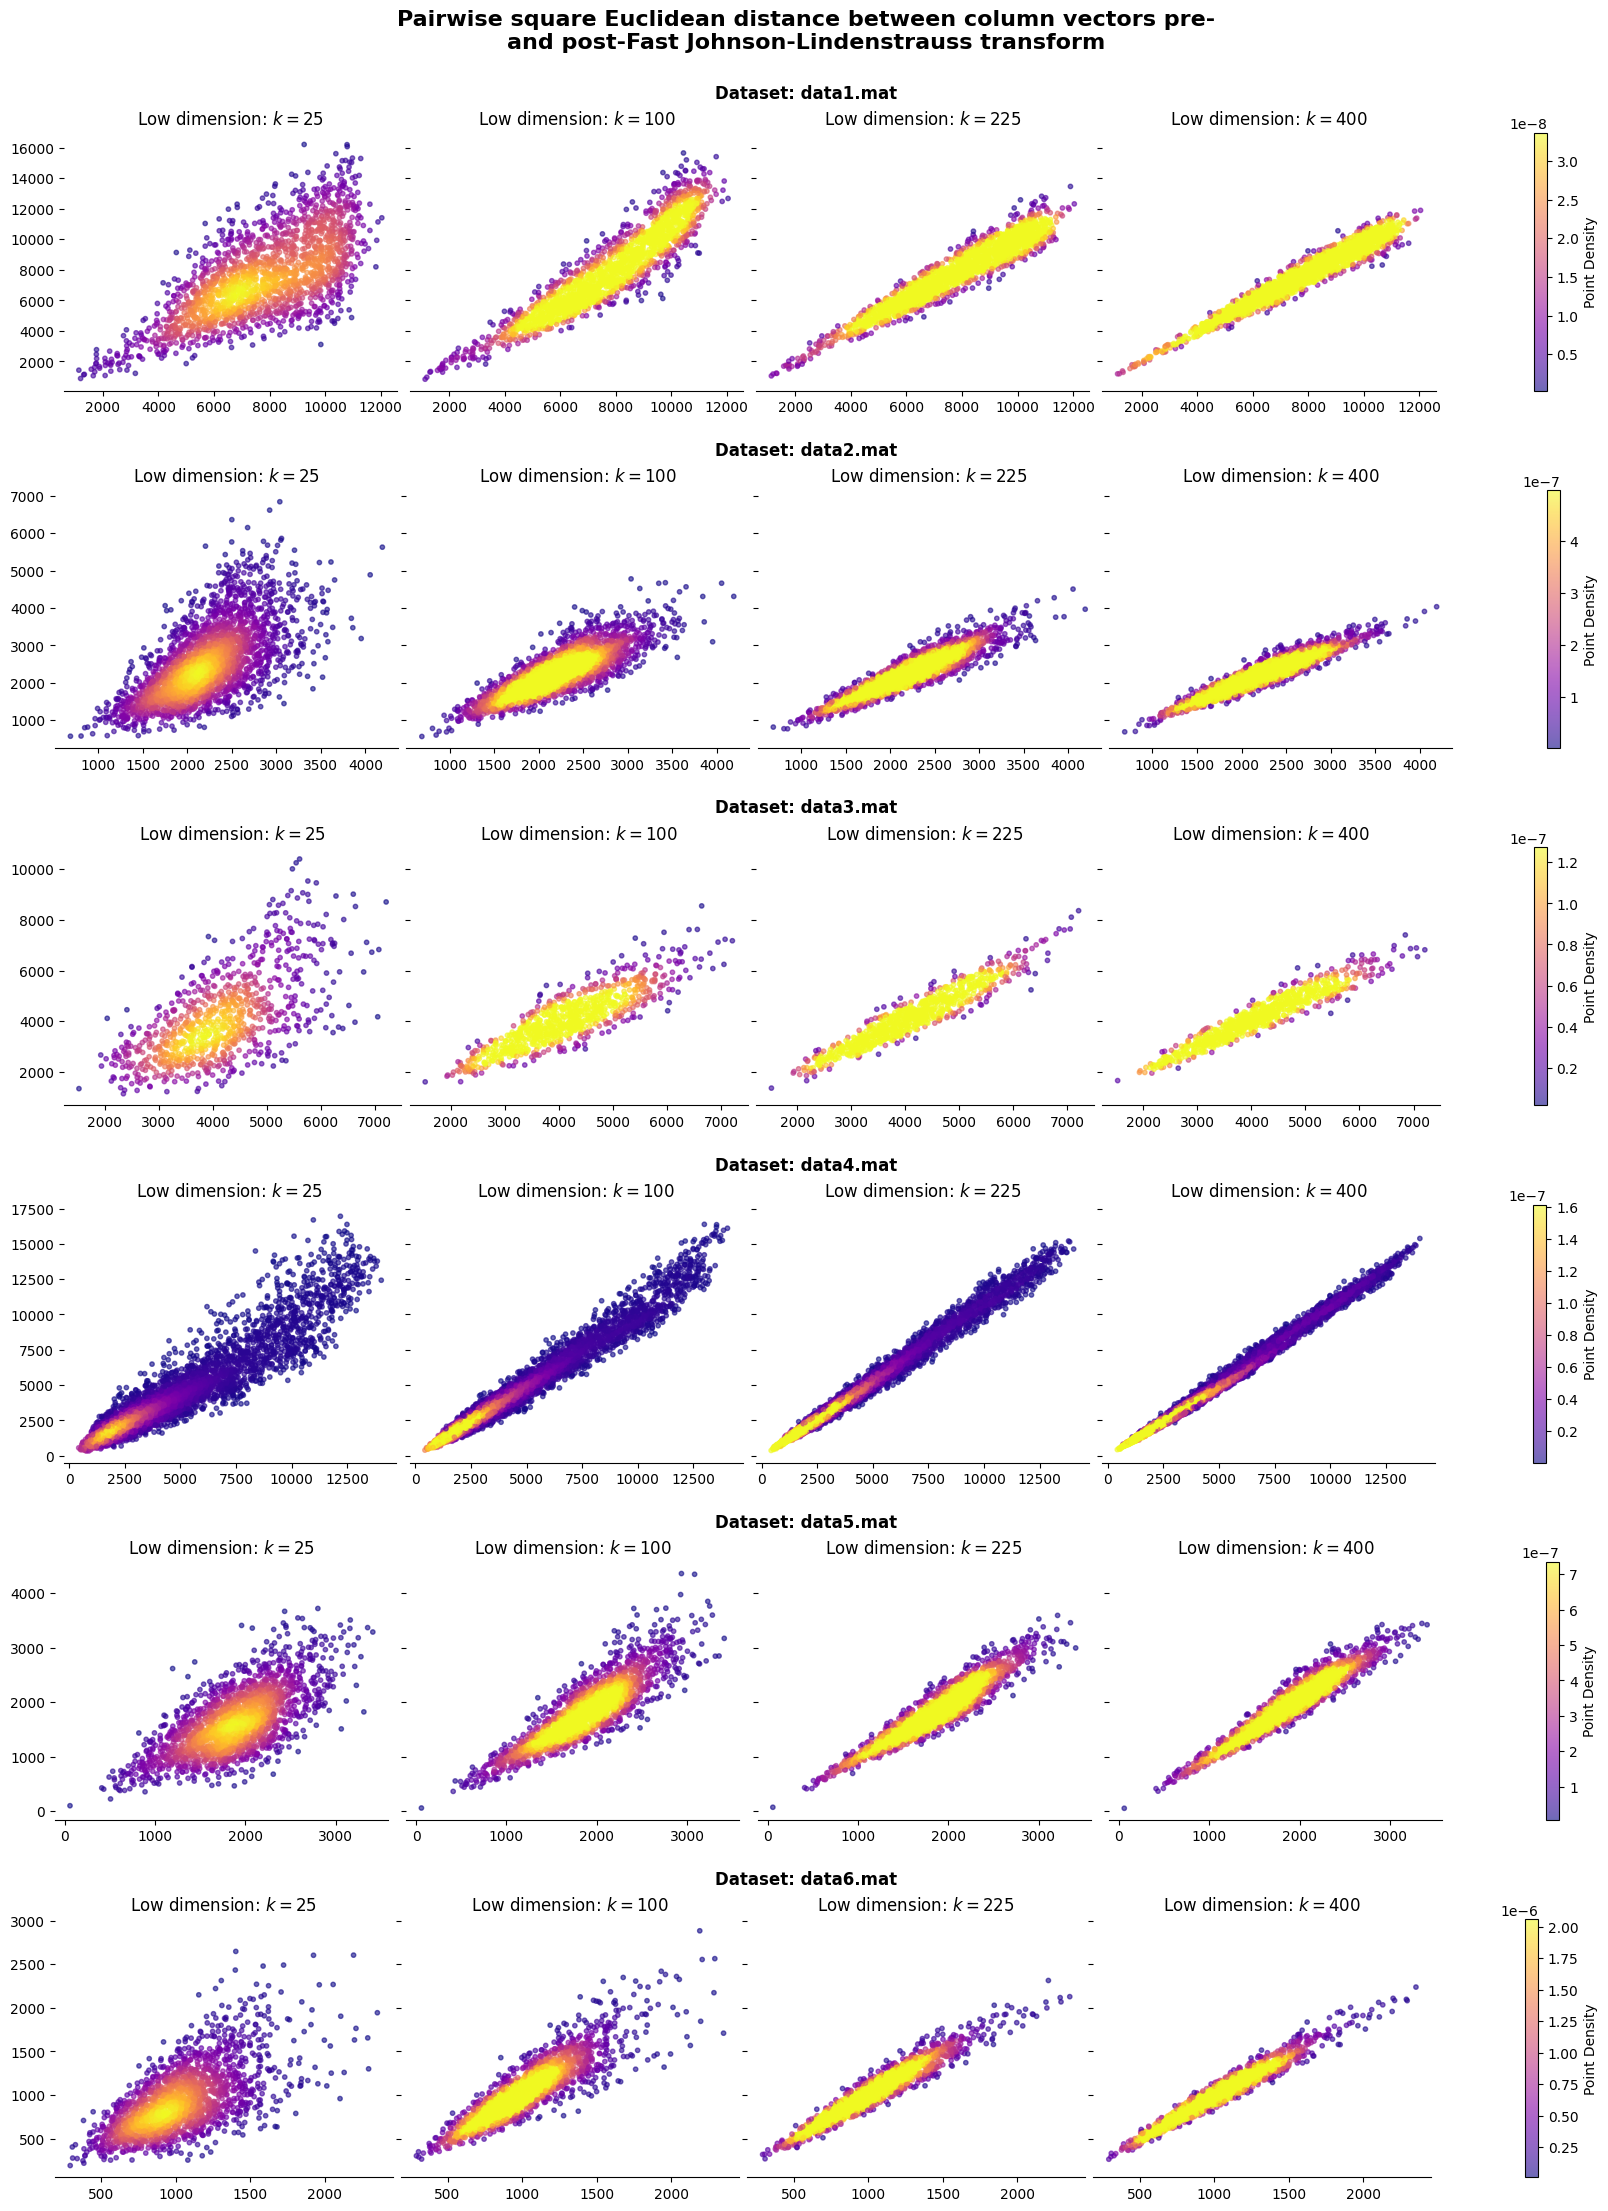

In [317]:
fig = _multi_scatter_supfig(data, ks, fast=True)

## Distortion ratio of the Johnson-Lindenstrauss transform
The second metric we consider in evaluating the Johnson-Lindenstrauss transform is the distortion ratio of the pairwise distances; that is, $$r_{j,i}=C_{j,i}/D_{j,i}$$ the ratio of the pairwise distance between columns $i$ and $j$ before and after the transform. The distributions of $r_{i,j}$ are centered about one in all cases; however, we again see a higher rate of distortion when $k$ is small. 

In [499]:
def _hist_dist(ax, xs):
    # histogram
    hist, bins = np.histogram(xs, bins=20)
    bar = ax.bar(bins[:-1], hist, 
                 width=np.diff(bins), 
                 edgecolor='black', 
                 linewidth=0.5,
                 alpha=0.7)
    
    # hide all except the bottom spine
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Set x-limits based on min and max conditions
    x_min = min(0,min(xs)) #np.floor(2 * min(0.5, xs.min()))/2
    x_max = max(2,max(xs)) #np.ceil(2 * max(1.5, xs.max()))/2
    ax.set_xlim(x_min, x_max)

    # Adjust the bottom spine
    spine_width = 2 
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['bottom'].set_linewidth(spine_width)

    # Move ticks away from the spine
    ax.tick_params(axis='x', direction='out', length=6, width=1, pad=10)
    ax.tick_params(axis='y', direction='out', length=6, width=1, pad=10)

    # Customize ticks to avoid overlap
    ax.set_xticks(np.arange(x_min, x_max+0.25, 0.5)) 
    
    return bar

In [500]:
def _multi_hist_subfig_dist(fig, axes, X, D, ks, fast=False):
    for idx, ax in enumerate(axes.ravel()):
        # evaluate the transform
        if fast:
            Y = jlt.fastjl(X, ks[idx])
        else:
            Y = jlt.jl(X, ks[idx])

        # compute new pariwise distances and distortion ratio
        C = pdist(Y.T, metric='sqeuclidean')

        xs = np.divide(C, D)

        # plot histogram
        bar = _hist_dist(ax, xs)

        # annotations
        ax.set_title(rf'$k={ks[idx]}$')

In [501]:
def _multi_hist_supfig_dist(data, ks, fast=False):
    # create main figure and subfigures
    fig = plt.figure(layout='constrained', figsize=(16, 22))
    subfigs = fig.subfigures(6, 1, hspace=0.05)
    
    for idx, subfig in enumerate(subfigs.ravel()):
        # make a subplots layout of axes
        axes = subfig.subplots(1,4, sharey=True)

        # get the correspoinding dataset and compute pariwise distances
        X = data[idx]
        D = pdist(X.T, metric='sqeuclidean')

        # make a multi-scatter plot on the axes
        _multi_hist_subfig_dist(subfig, axes, X, D, ks, fast=fast)

        # subfigure annotations
        subfig.suptitle(f'Dataset: data{idx+1}.mat',
                        fontweight='bold')
        
    # main figure annotations
    fig.suptitle(f"Distortion ratios for {'Fast ' if fast else ''}Johnson-Lindenstrauss transform\n",
                fontsize=16, fontweight='bold')
    
    return fig

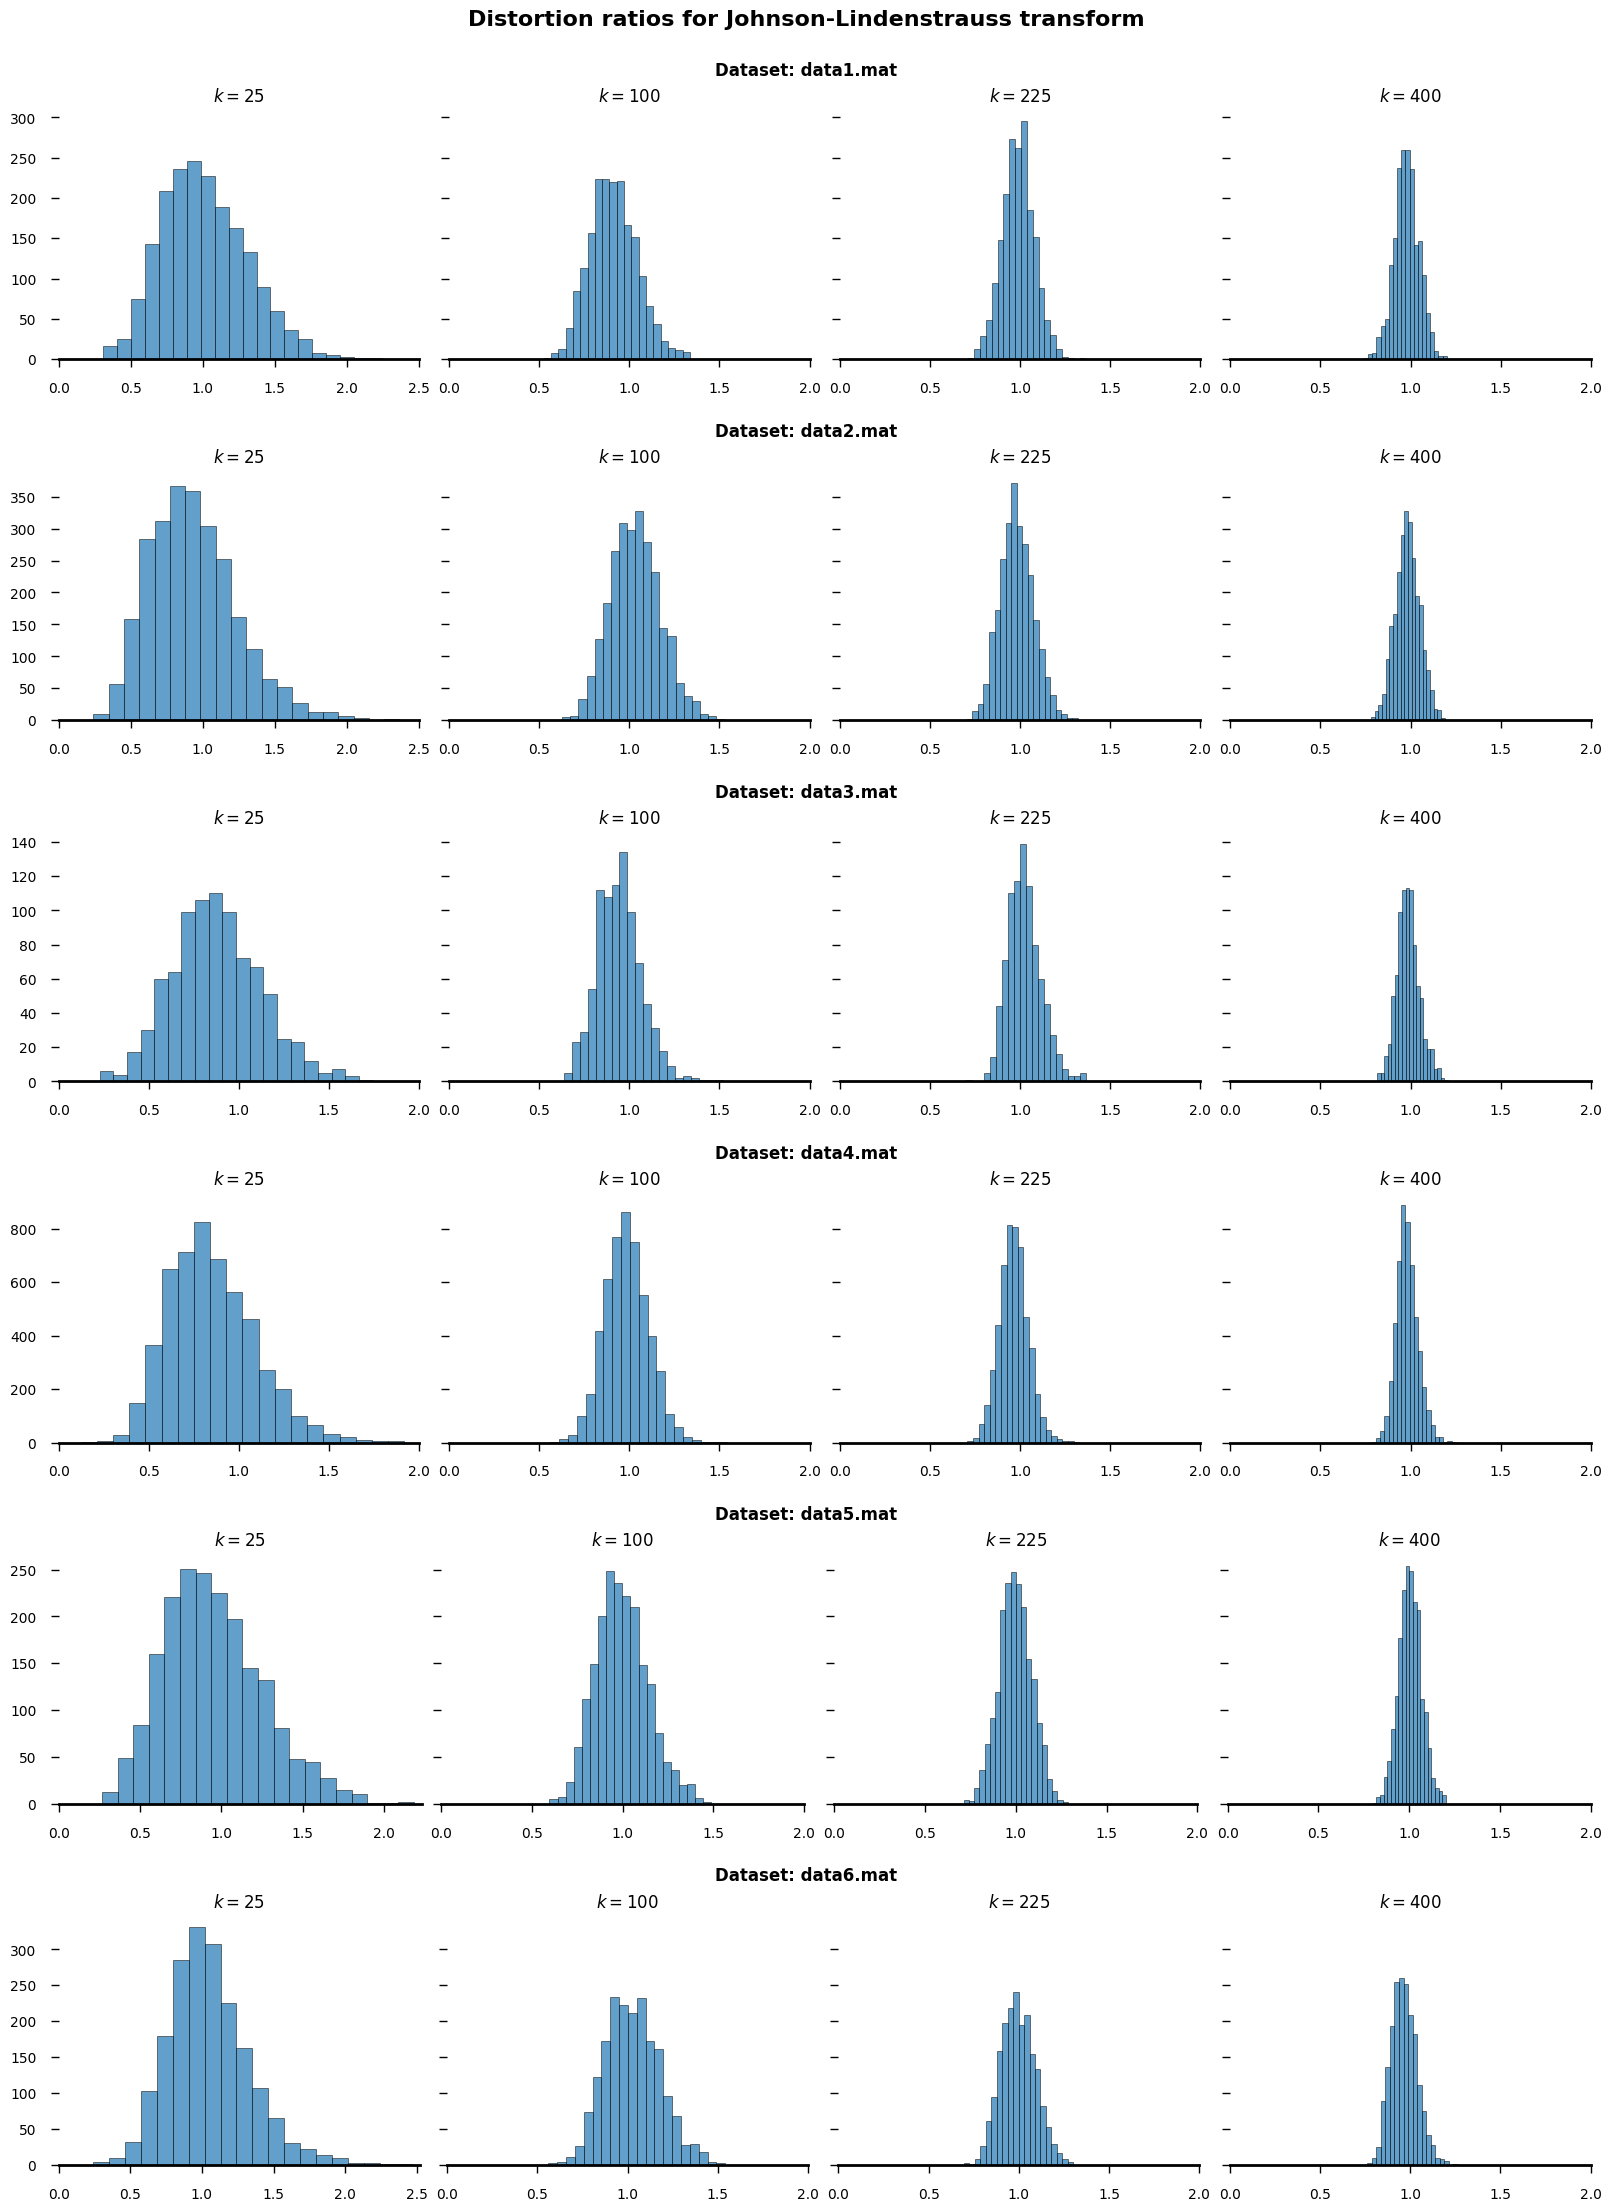

In [502]:
fig = _multi_hist_supfig_dist(data, ks, fast=False)

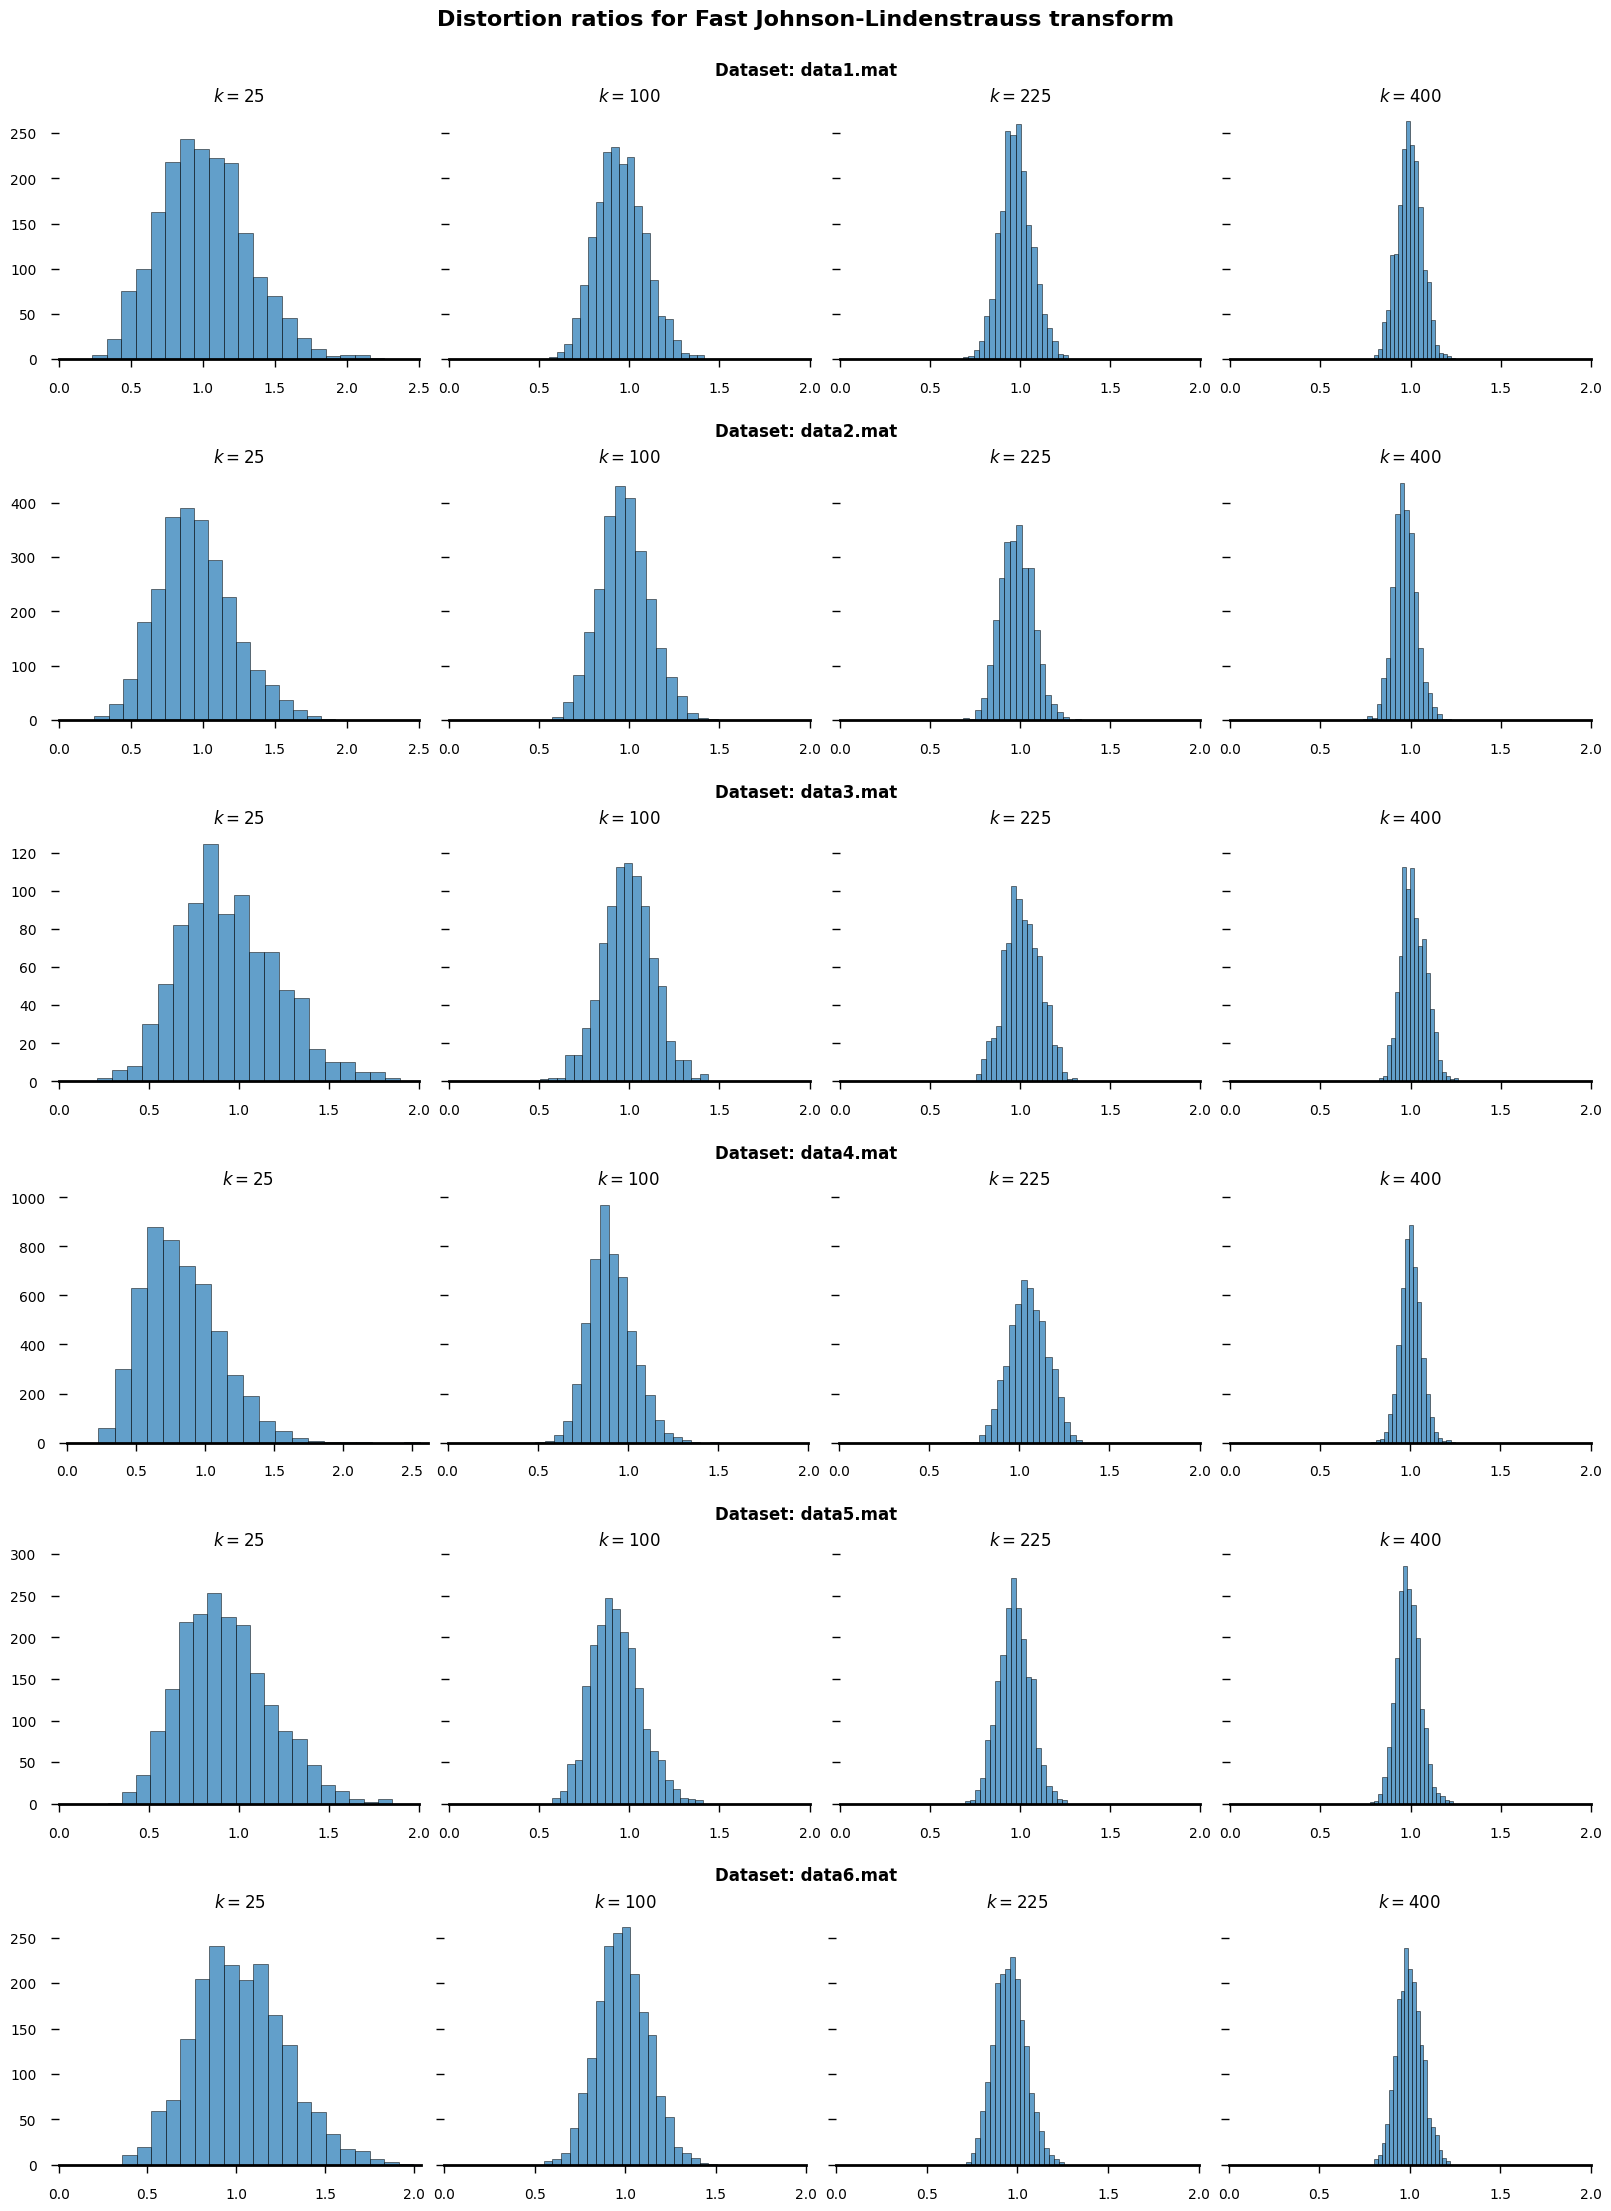

In [503]:
fig = _multi_hist_supfig_dist(data, ks, fast=True)

## Fraction of five-nearest neighbors 
Lastly, we consider the fraction of the five-nearest neighbors of each column vector $X_i$, which remain one of the five-nearest neighbors after the transform. As expected, we observe the same behavior regarding the choice of $k$.

In [535]:
def _hist_nbhd(ax, xs):
    # histogram
    hist = ax.hist(xs, 
                   bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                   edgecolor='black', 
                   alpha=0.7)
    
    # hide all except the bottom spine
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Set x-limits based on min and max conditions
    x_min = 0
    x_max = 1
    ax.set_xlim(x_min, x_max)

    # Adjust the bottom spine
    spine_width = 2 
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['bottom'].set_linewidth(spine_width)

    # Move ticks away from the spine
    ax.tick_params(axis='x', direction='out', length=6, width=1, pad=10)
    ax.tick_params(axis='y', direction='out', length=6, width=1, pad=10)

    # Customize ticks to avoid overlap
    ax.set_xticks(np.arange(x_min, x_max+0.1, 0.2)) 
    
    return hist

In [536]:
def _multi_hist_subfig_nbhd(fig, axes, X, D, ks, fast=False):
    for idx, ax in enumerate(axes.ravel()):
        # evaluate the transform
        if fast:
            Y = jlt.fastjl(X, ks[idx])
        else:
            Y = jlt.jl(X, ks[idx])

        # compute new pariwise distances and distortion ratio
        C = pdist(Y.T, metric='sqeuclidean')
        C = squareform(C)

        ncols = D.shape[1]
        xs=np.ndarray((ncols,), dtype=float)
        for col_idx in range(ncols):
            idxs1=np.argsort(D[:,col_idx])[:5]
            idxs2=np.argsort(C[:,col_idx])[:5]
            shared=np.intersect1d(idxs1, idxs2)
            xs[col_idx]=shared.size / 5

        # plot histogram
        hist = _hist_nbhd(ax, xs)

        # annotations
        ax.set_title(rf'$k={ks[idx]}$')

In [537]:
def _multi_hist_supfig_nbhd(data, ks, fast=False):
    # create main figure and subfigures
    fig = plt.figure(layout='constrained', figsize=(16, 22))
    subfigs = fig.subfigures(6, 1, hspace=0.05)
    
    for idx, subfig in enumerate(subfigs.ravel()):
        # make a subplots layout of axes
        axes = subfig.subplots(1,4, sharey=True)

        # get the correspoinding dataset and compute pariwise distances
        X = data[idx]
        D = pdist(X.T, metric='sqeuclidean')
        D = squareform(D)

        # make a multi-scatter plot on the axes
        _multi_hist_subfig_nbhd(subfig, axes, X, D, ks, fast=fast)

        # subfigure annotations
        subfig.suptitle(f'Dataset: data{idx+1}.mat',
                        fontweight='bold')
        
    # main figure annotations
    fig.suptitle(f"Fraction of 5 nearest neighbors for\n{'Fast ' if fast else ''}Johnson-Lindenstrauss transform\n",
                fontsize=16, fontweight='bold')
    
    return fig

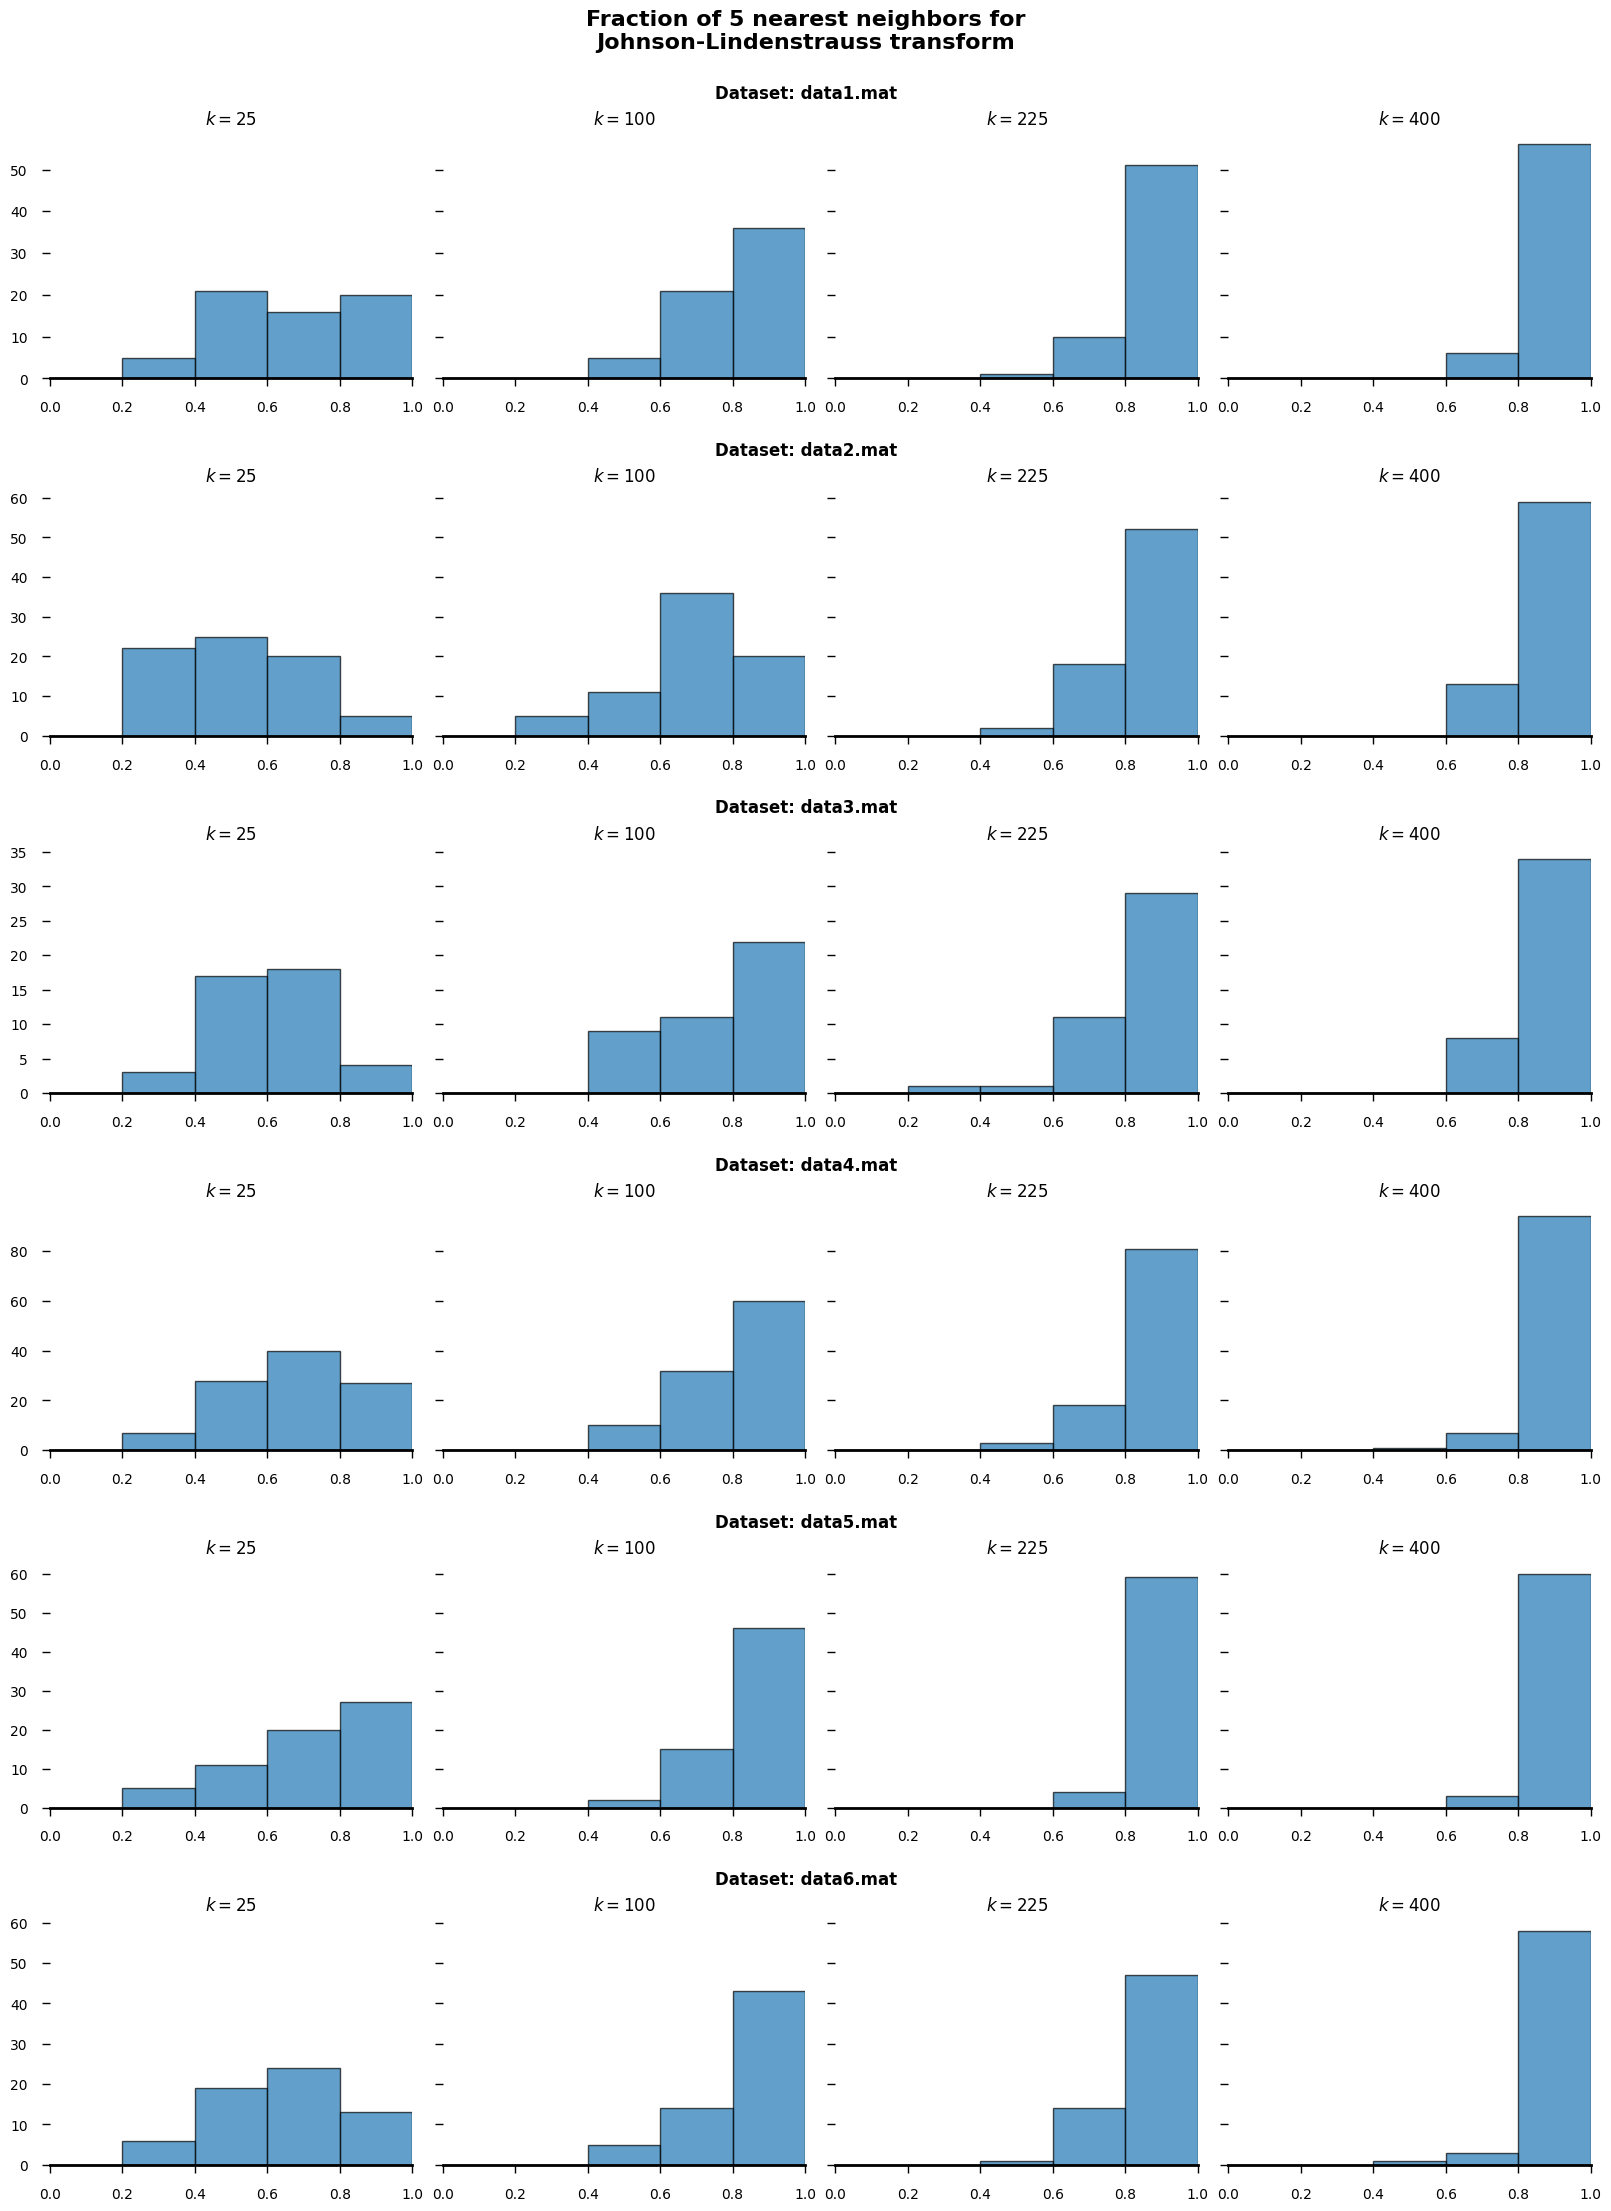

In [538]:
fig = _multi_hist_supfig_nbhd(data, ks, fast=False)

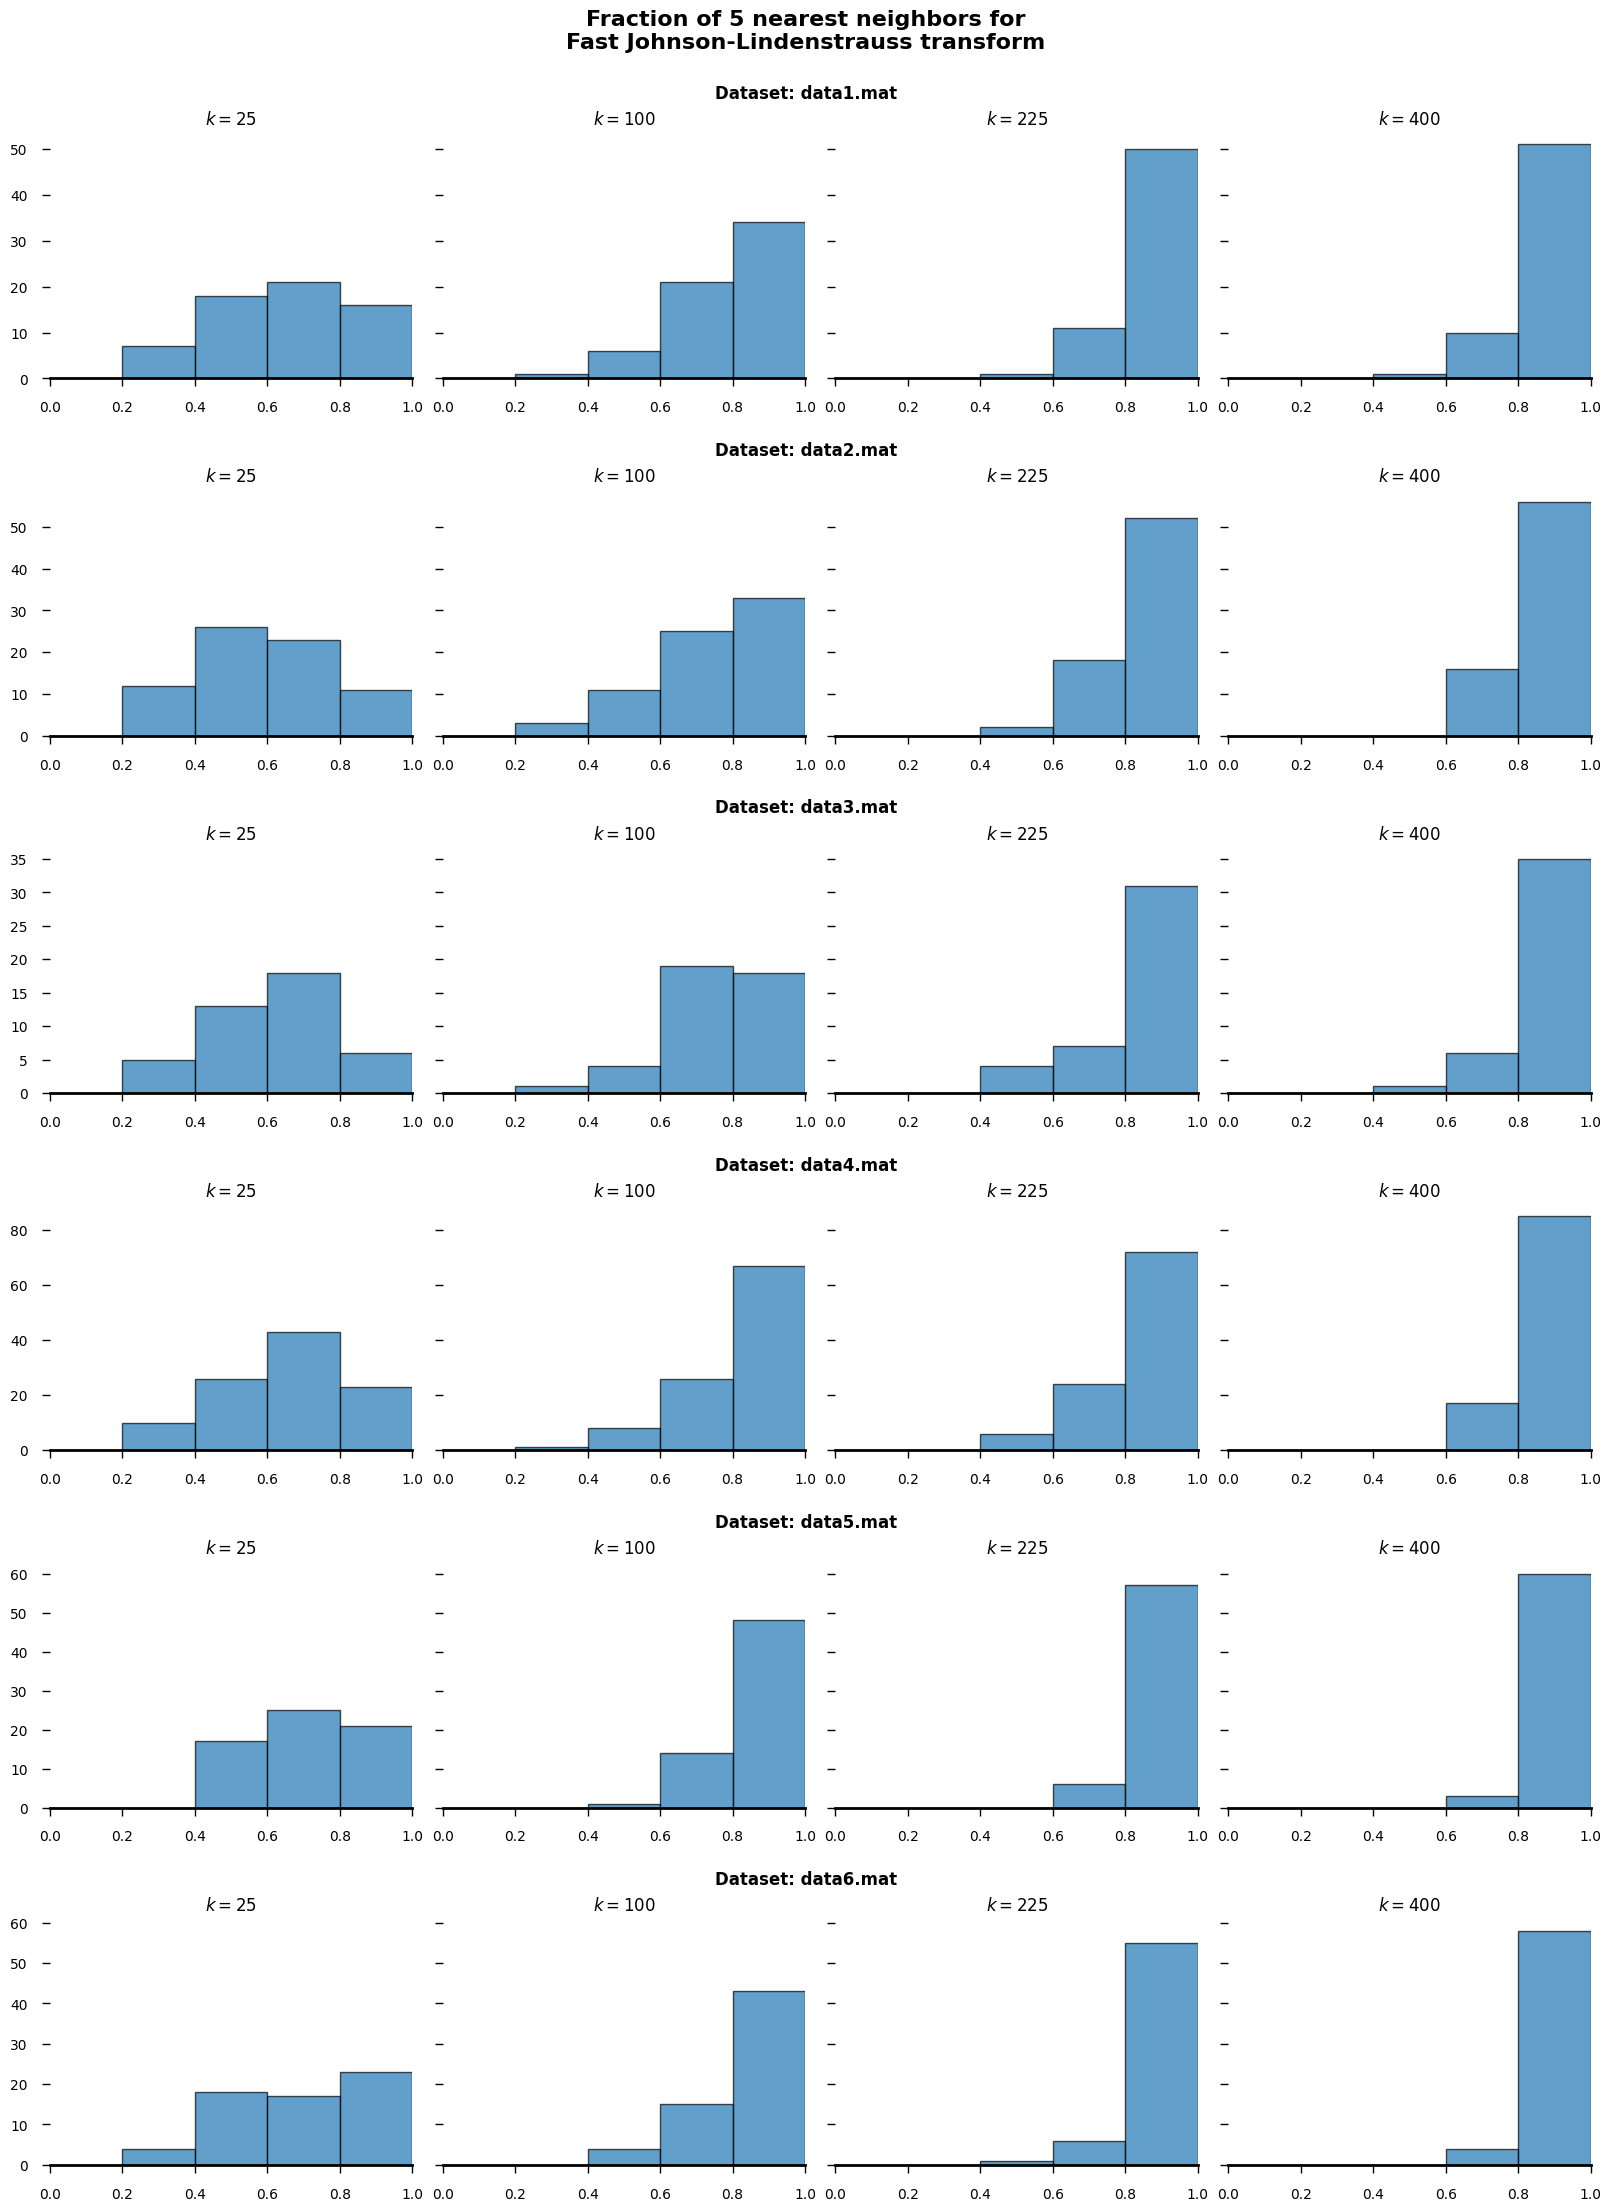

In [539]:
fig = _multi_hist_supfig_nbhd(data, ks, fast=True)

## CPU times
Here we compare the CPU times of performing the ordinary and fast transforms on each data-set, for each $k$. The results are shown in the figures below.

In [547]:
def _plot_cpu_times(data, ks, fast=False):
    fig, ax = plt.subplots()
    for idx, X in enumerate(data):
        times = []
        for k in ks:
            start = time.process_time()
            if fast:
                Y = jlt.fastjl(X, k)
            else:
                Y = jlt.jl(X, k)
            times.append(time.process_time() - start)
        ax.plot(ks, times, marker='o', label=f'data{idx+1}.mat')
        ax.text(
            ks[-1] * 1.02,
            times[-1],
            f'data{idx+1}.mat',
            horizontalalignment="left",
            verticalalignment="center",
        )

    # hide all except the bottom spine 
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # annotations
    ax.set_title(f"CPU times for computing the\n{'Fast' if fast else ''}Johnson-Lindenstrauss transform\n")
    ax.set_xlabel(r"Reduced dimension $k$")
    ax.set_ylabel("CPU time (seconds)")


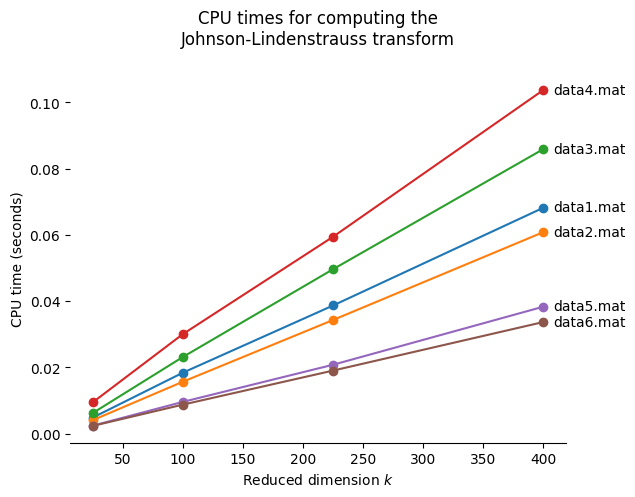

In [550]:
fig = _plot_cpu_times(data, ks, fast=False)

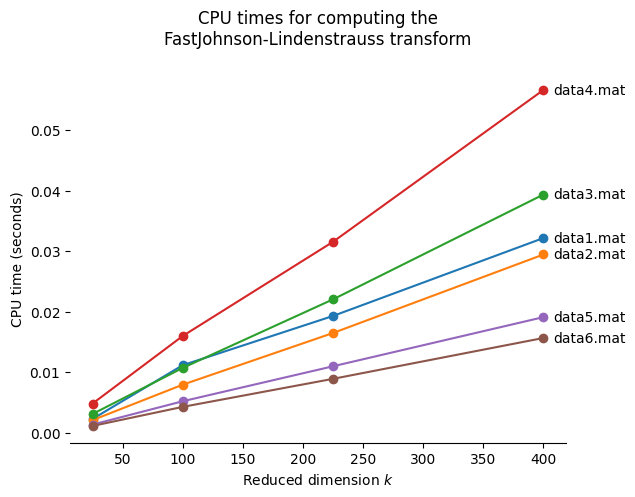

In [551]:
fig = _plot_cpu_times(data, ks, fast=True)